In [1]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import IPython.display as ipd
import warnings
warnings.filterwarnings("ignore")
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()
from joblib import dump, load

Using TensorFlow backend.


In [0]:
#Data preprocessing
folder_url = "/gdrive/My Drive/Colab Notebooks/Data/DSP Final/"

my_labels = ['yes','no','on','off','go','stop','up','down','left','right']
FIXED_RATE = 8000

#Read waves & labels
wave_list = []
label_list = []
for label in my_labels:
    audio_files = [file for file in os.listdir(folder_url + '/'+ label) if file.endswith('.wav')]
    for i, file in enumerate(audio_files):
        print(label, i)
        audio_data, audio_rate = librosa.load(folder_url + '/' + label + '/' + file, sr = 16000)
        #downsample to FIXED_RATE
        audio_data = librosa.resample(audio_data, audio_rate, FIXED_RATE)
        #remove samples with different lengths
        if(len(audio_data) == FIXED_RATE) : 
            wave_list.append(audio_data)
            label_list.append(label)

#Encode & onehot labels
labelEncoder = LabelEncoder()
labels_encoded = labelEncoder.fit_transform(label_list)
classes = np.array(labelEncoder.classes_)
labels_onehot = np_utils.to_categorical(labels_encoded, num_classes=len(my_labels))

#reshape wave from 2D into 3D
wave_list = np.array(wave_list).reshape(-1,FIXED_RATE,1)

#split train/dev data
x_train, x_dev, y_train, y_dev = train_test_split(wave_list, labels_onehot, stratify=labels_onehot, test_size = 0.2, shuffle=True)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

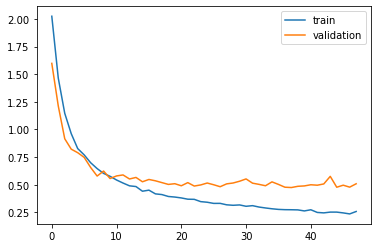

['/gdrive/My Drive/Colab Notebooks/Data/DSP Final/classes.joblib']

In [0]:
#Convolution network
#Model input
inputs = Input(shape=(FIXED_RATE,1))

#Convolution layer 1
x = Conv1D(8,13, activation='relu')(inputs)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Convolution layer 2
x = Conv1D(16, 11, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Convolution layer 3
x = Conv1D(32, 9, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Convolution layer 4
x = Conv1D(64, 7, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Flatten layer
x = Flatten()(x)

#Dense layer 1
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

#Dense layer 2
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

#Model output
outputs = Dense(len(my_labels), activation='softmax')(x)

#Model
model = Model(inputs, outputs)
model.summary()

#model settings
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10, min_delta=0.0001, verbose=1) 

#train model
history = model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=100, batch_size=32, callbacks=[early_stop])

#plot loss
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='validation') 
plt.legend() 
plt.show()

#save model
#model=load_model('best_model.hdf5')
dump(model, folder_url + 'model.joblib')
dump(classes, folder_url + 'classes.joblib')

In [9]:
#Prediction
pred_model = load(folder_url + 'model.joblib')

def predict(model, audio):
    audio = audio.reshape(1,8000,1)
    class_probs = model.predict(audio)
    best_index = np.argmax(class_probs[0])
    pred_class = classes[best_index]
    return pred_class

import random
index = random.randint(0, len(x_dev)-1)
print("index:", index)
audio = x_dev[index].ravel()
ipd.Audio(audio, rate=8000)
print("Audio:", classes[np.argmax(y_dev[index])])
print("Text:", predict(pred_model, audio))

corrects = 0
for index in range(len(x_dev)):
    #print(index)
    audio = x_dev[index].ravel()
    speech = classes[np.argmax(y_dev[index])]
    text = predict(pred_model, audio)
    if speech == text:
      corrects +=1
print('Accuracy:', corrects / len(x_dev))

index: 4204
Audio: go
Text: go
Accuracy: 0.9465165376495426
